# Step 1: Understand the Problem
The goal is to group similar movie reviews into clusters that represent genres (e.g., action, comedy, drama). Since the IMDB dataset doesn't explicitly provide genres for reviews, we will use unsupervised learning to discover patterns in the text.

# Step 2: Load and Explore the Dataset
The IMDB dataset contains 50,000 movie reviews labeled as positive or negative. For clustering, we will ignore the labels and focus on the text.

In [1]:
import pandas as pd
import string
import nltk
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.feature_extraction.text import TfidfVectorizer


In [2]:
# Load the IMDB dataset
dataset = pd.read_csv("IMDB Dataset.csv")

# Access the 'review' column directly
reviews = dataset['review'][:30000]  # Use a subset for efficiency

# Explore the dataset
print(f"Number of reviews: {len(reviews)}")
print("\nSample review:", reviews[0])

Number of reviews: 30000

Sample review: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the 

In [3]:
reviews.head()

0    One of the other reviewers has mentioned that ...
1    A wonderful little production. <br /><br />The...
2    I thought this was a wonderful way to spend ti...
3    Basically there's a family where a little boy ...
4    Petter Mattei's "Love in the Time of Money" is...
Name: review, dtype: object

In [4]:
reviews.isnull().sum()

0

In [5]:
reviews[100]

"This short film that inspired the soon-to-be full length feature - Spatula Madness - is a hilarious piece that contends against similar cartoons yielding multiple writers. The short film stars Edward the Spatula who after being fired from his job, joins in the fight against the evil spoons. This premise allows for some funny content near the beginning, but is barely present for the remainder of the feature. This film's 15-minute running time is absorbed by some odd-ball comedy and a small musical number. Unfortunately not much else lies below it. The plot that is set up doesn't really have time to show. But it's surely follows it plot better than many high-budget Hollywood films. This film is worth watching at least a few times. Take it for what it is, and don't expect a deep story."

# Step 3: Preprocess the Text
Text data needs to be converted into numerical features for clustering.

# 3.1 Tokenization and TF-IDF Vectorization
We will use TF-IDF to convert text into numerical features

In [6]:
# Clean the text data
print("\nCleaning text...")

# Remove HTML tags
def remove_html(data):
    pattern = re.compile('<.*?>')
    return pattern.sub(r'', data)

# Remove URLs
def remove_url(text):
    pattern = re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub(r'', text)

# Remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("[" 
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Remove punctuation
def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# Remove stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Apply all the cleaning functions
reviews = reviews.apply(remove_html)
reviews = reviews.apply(remove_url)
reviews = reviews.apply(remove_emoji)
reviews = reviews.apply(remove_punct)
reviews = reviews.apply(remove_stopwords)

# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(
    stop_words='english',  # Remove common words
    max_features=2000,     # Limit vocabulary size
    lowercase=True         # Convert text to lowercase
)

# Fit and transform the reviews
X = tfidf.fit_transform(reviews)
print(f"Shape of TF-IDF matrix: {X.shape}")


Cleaning text...
Shape of TF-IDF matrix: (30000, 2000)


# Step 4: Training clustering algorithms
we ues a K-Means,Agglomerative and DBSCAN 

In [7]:
# Set up clustering algorithms
n_clusters = 5  # We'll use 5 clusters for algorithms that need this parameter
algorithms = {
    'K-Means': KMeans(n_clusters=n_clusters, random_state=42),
    'Agglomerative': AgglomerativeClustering(n_clusters=n_clusters),
    'DBSCAN': DBSCAN(eps=0.5, min_samples=5)
}
X_dense = X.toarray() 

In [8]:
results = {}
# K-Means Clustering
print("\nRunning K-Means...")
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_clusters = kmeans.fit_predict(X_dense)
kmeans_silhouette = silhouette_score(X_dense, kmeans_clusters)
kmeans_calinski = calinski_harabasz_score(X_dense, kmeans_clusters)

results['K-Means'] = {
    'clusters': kmeans_clusters,
    'silhouette': kmeans_silhouette,
    'calinski': kmeans_calinski
}
print(f"Number of clusters: {len(np.unique(kmeans_clusters))}")
print(f"Silhouette Score: {kmeans_silhouette:.3f}")
print(f"Calinski-Harabasz Score: {kmeans_calinski:.3f}")




Running K-Means...


c:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 5
Silhouette Score: 0.003
Calinski-Harabasz Score: 112.563


In [9]:
# DBSCAN Clustering
print("\nRunning DBSCAN...")
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_clusters = dbscan.fit_predict(X_dense)
dbscan_silhouette = silhouette_score(X_dense, dbscan_clusters) if len(set(dbscan_clusters)) > 1 else -1
dbscan_calinski = calinski_harabasz_score(X_dense, dbscan_clusters) if len(set(dbscan_clusters)) > 1 else -1

results['DBSCAN'] = {
    'clusters': dbscan_clusters,
    'silhouette': dbscan_silhouette,
    'calinski': dbscan_calinski
}
print(f"Number of clusters: {len(np.unique(dbscan_clusters))}")
print(f"Silhouette Score: {dbscan_silhouette:.3f}")
print(f"Calinski-Harabasz Score: {dbscan_calinski:.3f}")



Running DBSCAN...
Number of clusters: 1
Silhouette Score: -1.000
Calinski-Harabasz Score: -1.000


In [10]:
# Agglomerative Clustering
print("\nRunning Agglomerative Clustering...")
agglomerative = AgglomerativeClustering(n_clusters=5)
agglomerative_clusters = agglomerative.fit_predict(X_dense)
agglomerative_silhouette = silhouette_score(X_dense, agglomerative_clusters)
agglomerative_calinski = calinski_harabasz_score(X_dense, agglomerative_clusters)

results['Agglomerative Clustering'] = {
    'clusters': agglomerative_clusters,
    'silhouette': agglomerative_silhouette,
    'calinski': agglomerative_calinski
}
print(f"Number of clusters: {len(np.unique(agglomerative_clusters))}")
print(f"Silhouette Score: {agglomerative_silhouette:.3f}")
print(f"Calinski-Harabasz Score: {agglomerative_calinski:.3f}")



Running Agglomerative Clustering...
Number of clusters: 5
Silhouette Score: -0.002
Calinski-Harabasz Score: 40.665


In [11]:
# visualize the results
import matplotlib.pyplot as plt
import seaborn as sns
acc = []
for key, value in results.items():
    acc.append([key, value['silhouette'], value['calinski']])

acc_df = pd.DataFrame(acc, columns=['Algorithm', 'Silhouette Score', 'Calinski-Harabasz Score'])
print(acc_df)

                  Algorithm  Silhouette Score  Calinski-Harabasz Score
0                   K-Means           0.00288               112.563328
1                    DBSCAN          -1.00000                -1.000000
2  Agglomerative Clustering          -0.00246                40.665345


c:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
c:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


Text(0, 0.5, 'Calinski-Harabasz Score')

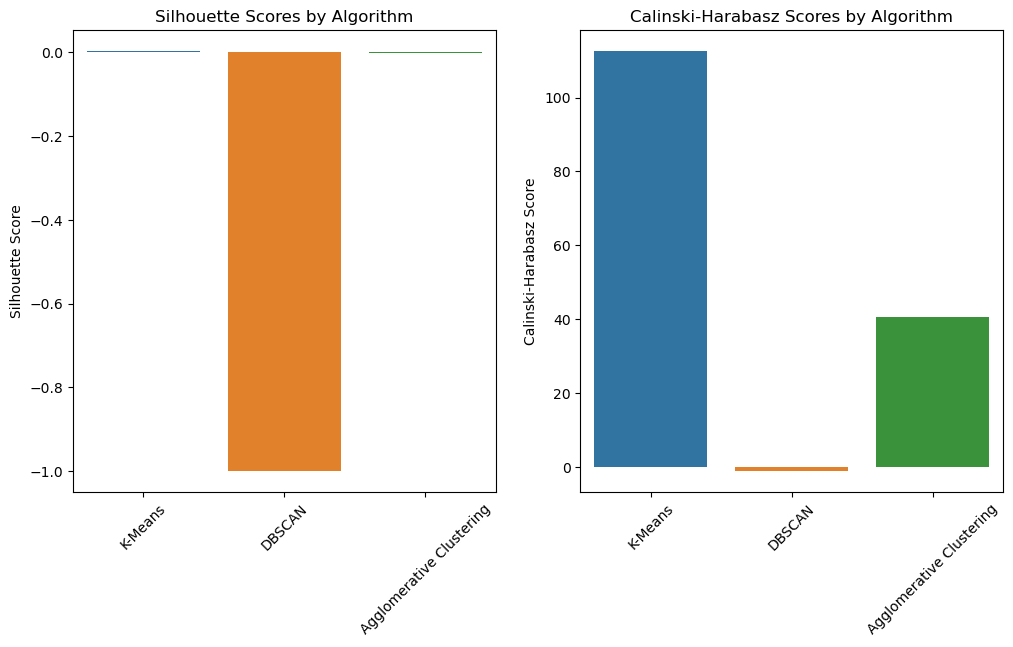

In [21]:
# Plot the results
# Plot Silhouette Scores
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
algorithms = list(results.keys())
silhouette_scores = [results[alg]['silhouette'] for alg in algorithms]
sns.barplot(x=algorithms, y=silhouette_scores)
plt.title('Silhouette Scores by Algorithm')
plt.xticks(rotation=45)
plt.ylabel('Silhouette Score')

# Plot Calinski-Harabasz Scores
plt.subplot(1, 2, 2)
calinski_scores = [results[alg]['calinski'] for alg in algorithms]
sns.barplot(x=algorithms, y=calinski_scores)
plt.title('Calinski-Harabasz Scores by Algorithm')
plt.xticks(rotation=45)
plt.ylabel('Calinski-Harabasz Score')


# Step 5: Visualize Clusters
We will use PCA to reduce the dimensionality of the TF-IDF matrix and visualize the clusters in 2D.

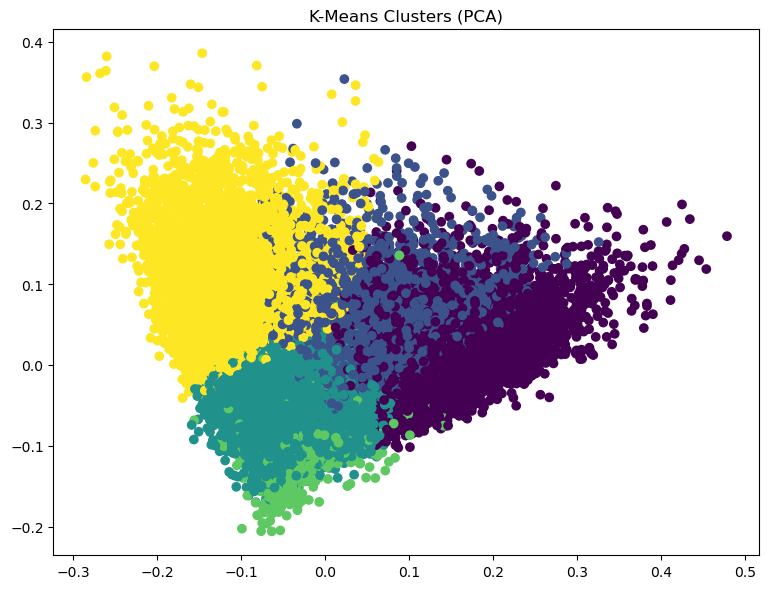

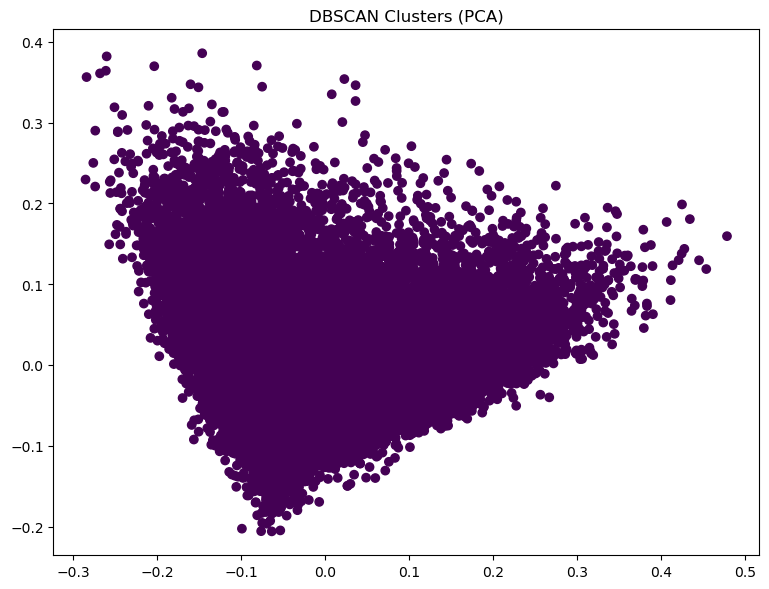

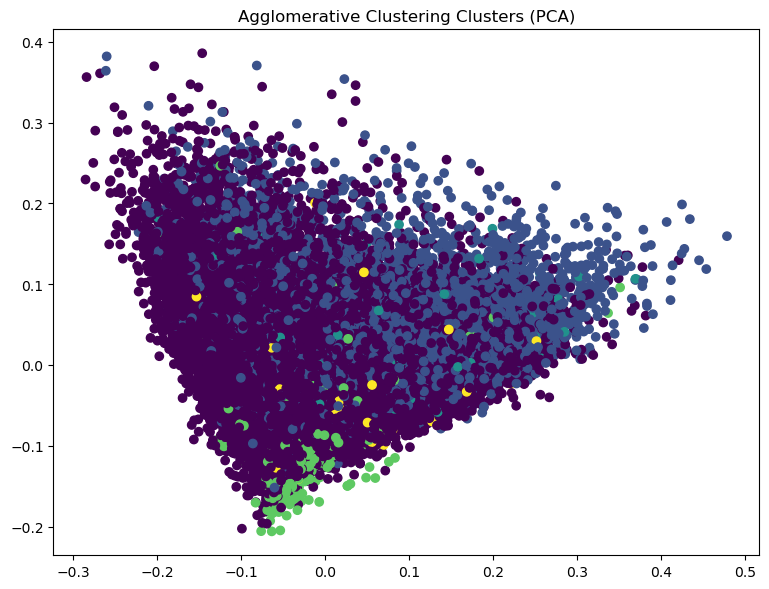

In [12]:
import matplotlib.pyplot as plt

# Perform PCA on the TF-IDF matrix
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_dense)

# Assign pca_result to X_pca
pca_result = X_pca

for name, result in results.items():
    plt.figure(figsize=(15, 6))
    
    # Plot PCA
    plt.subplot(1, 2, 1)
    plt.scatter(pca_result[:, 0], pca_result[:, 1], 
                c=result['clusters'], cmap='viridis')
    plt.title(f'{name} Clusters (PCA)')
    
    plt.tight_layout()
    plt.show()

# Step 6: Interpret Clusters
We will analyze the top words in each cluster to understand their themes.

In [13]:
# Get feature names (words) from TF-IDF
feature_names = tfidf.get_feature_names_out()

# Print top words per cluster
for i in range(5):
    print(f"\nCluster {i} Top Words:")
    cluster_center = kmeans.cluster_centers_[i]
    top_indices = cluster_center.argsort()[-10:][::-1]  # Top 10 words
    print([feature_names[idx] for idx in top_indices])


Cluster 0 Top Words:
['movie', 'movies', 'good', 'like', 'really', 'watch', 'great', 'time', 'dont', 'think']

Cluster 1 Top Words:
['bad', 'movie', 'like', 'really', 'good', 'movies', 'film', 'dont', 'acting', 'plot']

Cluster 2 Top Words:
['film', 'movie', 'story', 'like', 'time', 'great', 'good', 'love', 'life', 'best']

Cluster 3 Top Words:
['series', 'episode', 'episodes', 'season', 'tv', 'like', 'good', 'shows', 'time', 'characters']

Cluster 4 Top Words:
['film', 'films', 'like', 'good', 'story', 'movie', 'really', 'great', 'time', 'people']
